# How popular are different social movements over time?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 18/11/24

**Authors**: GBemi Banjo, Amelia Dunn

**Objective**:🌟 Further process the GDELT all_process_data to get popularity of different social movements or events over time.

In [4]:
import os
import json
import requests
import glob

import pandas as pd

from dotenv import load_dotenv
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.display import Image

import sqlite3
from sqlalchemy import create_engine, text

## 1. Processing GDELT data 

In [5]:
df = pd.read_csv('../data_amelia/raw/2014_protest_data.csv')
df.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,281510593,20140101,201401,2014,2014.0027,TUR,TURKEY,TUR,NaN,NaN,...,NaN,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"
1,281515425,20140101,201401,2014,2014.0027,USA,UNITED STATES,USA,NaN,NaN,...,NaN,3,"Upper Providence, Pennsylvania, United States",US,USPA,39.9551,-75.4230,1197544,20140101,http://www.montgomerynews.com/articles/2014/01...
2,281515426,20140101,201401,2014,2014.0027,USA,UNITED STATES,USA,NaN,NaN,...,NaN,3,"Valley Park, Pennsylvania, United States",US,USPA,40.1093,-75.1052,1207721,20140101,http://www.montgomerynews.com/articles/2014/01...
3,281515427,20140101,201401,2014,2014.0027,USA,ALASKA,USA,NaN,NaN,...,NaN,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"
4,281518684,20140101,201401,2014,2014.0027,USA,ALASKA,USA,NaN,NaN,...,-740445,2,"Alaska, United States",US,USAK,61.3850,-152.2680,AK,20140101,"Zaman website, Istanbul/BBC Monitoring/(c) BBC"


Justification for each of the columns chosen:

| Heading | Justification |
| :---: | :---: |
| Global Event ID | To have an exact numeric value to categorise the event. |
| SQL Date | So that we can evaluate when social movements peaked and for how long. |
| Actor 1 Country Code | To make sure that the event is local to the USA. |
| Goldstein Scale | To measure how cooperative or conflictual interactions between countries are. |
| Num Mentions | To get a measure of how much interaction different social movements have. |
| Avg Tone | To get the average sentiment of all documents that mention a specific event. |

In [5]:
data_filepath = '../data_amelia/processed/'
file_list = glob.glob(f"{data_filepath}/*_protest_data.csv")

# Concatenate all DataFrames
combined_df = pd.concat([pd.read_csv(file, dtype={'SQLDATE': str}) for file in file_list], ignore_index=True)

# Getting dates into the correct form for consistency

combined_df['SQLDATE'] = pd.to_datetime(combined_df['SQLDATE'].astype(str), format='%Y%m%d').dt.strftime('%Y-%m-%d')

# Filtering then renaming to get relevant data and improve clarity
relevant_columns = ['GLOBALEVENTID', 'SQLDATE', 'Actor1CountryCode', 'SOURCEURL', 'GoldsteinScale', 'NumMentions', 'AvgTone']
protest_data = combined_df[relevant_columns].copy()
protest_data.rename(columns={'GLOBALEVENTID': 'EventID', 'SQLDATE': 'Date', 'Actor1CountryCode': 'RelevantCountry'}, inplace= True)

protest_data

,EventID,Date,RelevantCountry,SOURCEURL,GoldsteinScale,NumMentions,AvgTone
0,6.132572e+08,2017-01-01,NaN,http://wypr.org/?page=1901,-6.5,16,-2.656748
1,6.133204e+08,2017-01-01,USA,http://www.dailyitem.com/news/local_news/pensi...,-6.5,2,-3.514377
2,6.133279e+08,2017-01-01,USA,http://www.foxnews.com/politics/2015/05/08/uc-...,-6.5,9,-6.250000
3,6.133279e+08,2017-01-01,USA,http://www.foxnews.com/politics/2015/05/08/uc-...,-6.5,1,-6.250000
4,6.133821e+08,2017-01-01,NaN,http://www.azcentral.com/picture-gallery/news/...,-6.5,2,-1.166781
...,...,...,...,...,...,...,...
299775,1.021377e+09,2021-12-31,NaN,https://qctimes.com/news/state-and-regional/go...,-6.5,6,-3.088235
299776,1.021377e+09,2021-12-31,NaN,https://qctimes.com/news/state-and-regional/go...,-6.5,2,-3.088235
299777,1.021378e+09,2021-12-31,USA,https://qctimes.com/news/state-and-regional/go...,-6.5,2,-3.088235
299778,1.021387e+09,2021-12-31,USA,https://www.cbs19.tv/article/news/local/new-yo...,-6.5,6,4.074703


In [4]:
protest_data.to_csv('../data_amelia/processed/all_protest_data.csv', index=False)

## Finding trends 
Need to move into processing later - just wrote this for some clarity on the sort of movements we would investigate and how we would go about doing this.

/tmp/ipykernel_410/1324347034.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = pd.to_datetime(filtered_df['Date']).dt.year


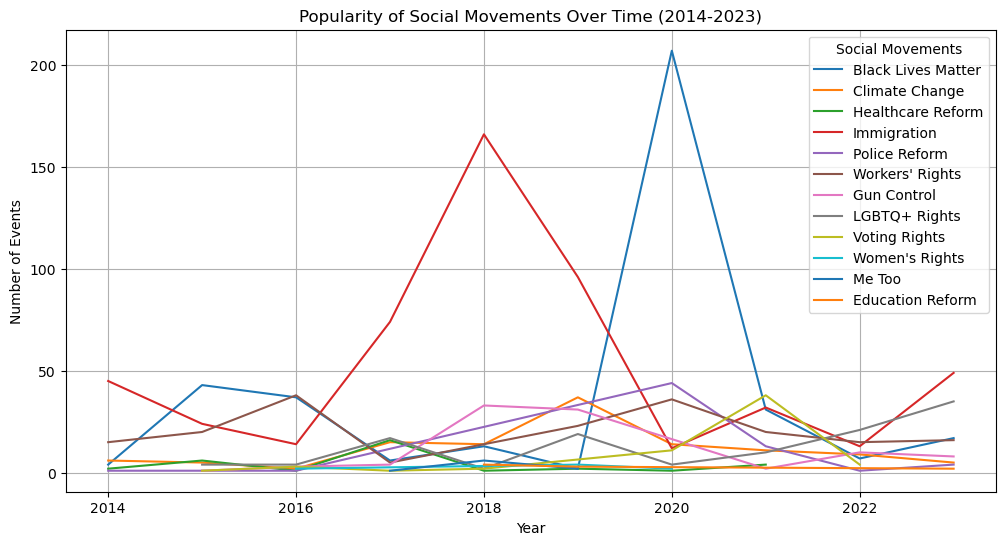

In [9]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Load the data
data_filepath = '../data_amelia/processed/all_protest_data.csv'
df = pd.read_csv(data_filepath)

# Predefined keywords for social movements
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
    'LGBTQ+ Rights': ['lgbtq', 'pride', 'gay-rights'],
    'Gun Control': ['gun-control', 'gun-violence', 'nra'],
    'Immigration': ['immigration', 'border', 'migrant', 'refugee'],
    'Women\'s Rights': ['women-rights', 'gender-equality', 'feminism'],
    'Native American Rights': ['native-american-rights', 'indigenous-rights', 'tribal-sovereignty'],
    'Healthcare Reform': ['healthcare-reform', 'obamacare', 'medicare-for-all'],
    'Workers\' Rights': ['labor-rights', 'union', 'workers-strike', 'minimum-wage'],
    'Education Reform': ['education-reform', 'student-loans', 'teacher-strike'],
    'Voting Rights': ['voting-rights', 'voter-suppression', 'election-reform'],
    'Police Reform': ['police-reform', 'defund-police', 'police-accountability']
}

# Function to assign themes based on SOURCEURL
def assign_theme(url):
    if pd.isna(url):
        return 'Other'
    for theme, words in keywords.items():
        if any(re.search(r'\b' + re.escape(word) + r'\b', url.lower()) for word in words):
            return theme
    return 'Other'

# Add a Theme column
df['Theme'] = df['SOURCEURL'].apply(assign_theme)

# Filter data for the USA and relevant themes
filtered_df = df[(df['RelevantCountry'] == 'USA') & (df['Theme'] != 'Other')]

# Aggregate data by theme and year
filtered_df['Year'] = pd.to_datetime(filtered_df['Date']).dt.year
theme_trends = filtered_df.groupby(['Year', 'Theme']).agg(
    TotalMentions=('NumMentions', 'sum'),
    AvgTone=('AvgTone', 'mean'),
    EventCount=('EventID', 'count')
).reset_index()

# Save the aggregated data for further use
#output_filepath = '../data_amelia/theme_trends_2014_2023.csv'
#theme_trends.to_csv(output_filepath, index=False)

# Plot popularity trends
plt.figure(figsize=(12, 6))
for theme in theme_trends['Theme'].unique():
    theme_data = theme_trends[theme_trends['Theme'] == theme]
    plt.plot(theme_data['Year'], theme_data['EventCount'], label=theme)

plt.title('Popularity of Social Movements Over Time (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.legend(title='Social Movements')
plt.grid(True)
plt.show()


In [13]:
import pandas as pd
import re
from collections import defaultdict

def identify_themes(data, keywords):
    """
    Analyze social movement themes and their popularity over time.

    Args:
        data (pd.DataFrame): The processed GDELT data.
        keywords (dict): Dictionary of themes and their associated keywords.

    Returns:
        pd.DataFrame: A DataFrame with the count of mentions for each theme by year.
    """
    # Add a 'Year' column from the 'Date'
    data['Year'] = pd.to_datetime(data['Date']).dt.year
    
    # Create a dictionary to store counts for each theme by year
    theme_counts = defaultdict(lambda: defaultdict(int))
    
    # Analyze each URL for matches to keywords
    for index, row in data.iterrows():
        url = str(row['SOURCEURL']).lower()
        year = row['Year']
        
        for theme, theme_keywords in keywords.items():
            if any(re.search(rf'\b{kw}\b', url) for kw in theme_keywords):
                theme_counts[theme][year] += 1
    
    # Convert theme_counts to a DataFrame
    results = []
    for theme, counts in theme_counts.items():
        for year, count in counts.items():
            results.append({'Theme': theme, 'Year': year, 'Mentions': count})
    
    theme_df = pd.DataFrame(results)
    
    return theme_df

# Load your processed GDELT data (ensure it has the 'SOURCEURL' and 'Date' columns)
data_filepath = '../data_amelia/processed/all_protest_data.csv'
data = pd.read_csv(data_filepath)

# Run the analysis
theme_analysis = identify_themes(data, keywords)

# Save the theme analysis results
#theme_analysis.to_csv('social_movements_theme_analysis.csv', index=False)

# Display the first few rows of the results
theme_analysis


,Theme,Year,Mentions
0,Immigration,2017.0,188
1,Immigration,2016.0,46
2,Immigration,2018.0,448
3,Immigration,NaN,1
4,Immigration,NaN,1
...,...,...,...
8013,Police Reform,2022.0,2
8014,Police Reform,2020.0,76
8015,Police Reform,2019.0,2
8016,Police Reform,2023.0,9


## 2. Further processing using SQLite

Load CSV and Connect to SQLite Database

In [6]:
# Load the CSV file into a Pandas DataFrame
csv_filepath = '../data_amelia/processed/all_protest_data.csv'  
data = pd.read_csv(csv_filepath)

# Connect to SQLite database (or create it if it doesn't exist)
db_path = '../data_amelia/processed/social_movements.db'  # Database file name
conn = sqlite3.connect(db_path)

# Cursor to execute SQL commands
cursor = conn.cursor()


Create a Table in SQLite

In [8]:
# Drop the existing table
conn.execute("DROP TABLE IF EXISTS SocialMovements;")

# SQL command to create a table
create_table_query = text("""
CREATE TABLE IF NOT EXISTS SocialMovements (
    EventID INTEGER PRIMARY KEY,
    Date TEXT,
    RelevantCountry TEXT,
    SOURCEURL TEXT,
    GoldsteinScale REAL,
    NumMentions INTEGER,
    AvgTone REAL

conn.commit()
);
""")


In [9]:
# Insert data from DataFrame to SQLite
data.to_sql('SocialMovements', conn, if_exists='append', index=False)

print(f"Data successfully inserted into {db_path}.")


Data successfully inserted into ../data_amelia/processed/social_movements.db.


test succes with a simple query;

In [10]:
# Example query
query = "SELECT * FROM SocialMovements LIMIT 5;"
result = pd.read_sql_query(query, conn)

print(result)


       EventID        Date RelevantCountry  \
0  613257215.0  2017-01-01            None   
1  613320430.0  2017-01-01             USA   
2  613327918.0  2017-01-01             USA   
3  613327926.0  2017-01-01             USA   
4  613382062.0  2017-01-01            None   

                                           SOURCEURL  GoldsteinScale  \
0                         http://wypr.org/?page=1901            -6.5   
1  http://www.dailyitem.com/news/local_news/pensi...            -6.5   
2  http://www.foxnews.com/politics/2015/05/08/uc-...            -6.5   
3  http://www.foxnews.com/politics/2015/05/08/uc-...            -6.5   
4  http://www.azcentral.com/picture-gallery/news/...            -6.5   

   NumMentions   AvgTone  
0           16 -2.656748  
1            2 -3.514377  
2            9 -6.250000  
3            1 -6.250000  
4            2 -1.166781  


In [11]:
conn.close()


## Investigating using SQLite:

*This is just some more checking and will be moved later into a seperate file

In [14]:
import sqlite3
import pandas as pd

# Connect to the database
db_path = '../data_amelia/processed/social_movements.db'
conn = sqlite3.connect(db_path)

# Predefined keywords for social movements
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
    'LGBTQ+ Rights': ['lgbtq', 'pride', 'gay-rights'],
    'Gun Control': ['gun-control', 'gun-violence', 'nra'],
    'Immigration': ['immigration', 'border', 'migrant', 'refugee'],
    'Women\'s Rights': ['women-rights', 'gender-equality', 'feminism'],
    'Native American Rights': ['native-american-rights', 'indigenous-rights', 'tribal-sovereignty'],
    'Healthcare Reform': ['healthcare-reform', 'obamacare', 'medicare-for-all'],
    'Workers\' Rights': ['labor-rights', 'union', 'workers-strike', 'minimum-wage'],
    'Education Reform': ['education-reform', 'student-loans', 'teacher-strike'],
    'Voting Rights': ['voting-rights', 'voter-suppression', 'election-reform'],
}

# Generate dynamic queries for each movement
movement_data = {}
for movement, terms in keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions, 
        AVG(GoldsteinScale) AS AvgGoldstein, 
        AVG(AvgTone) AS AvgTone
    FROM SocialMovements
    WHERE {term_conditions}
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)


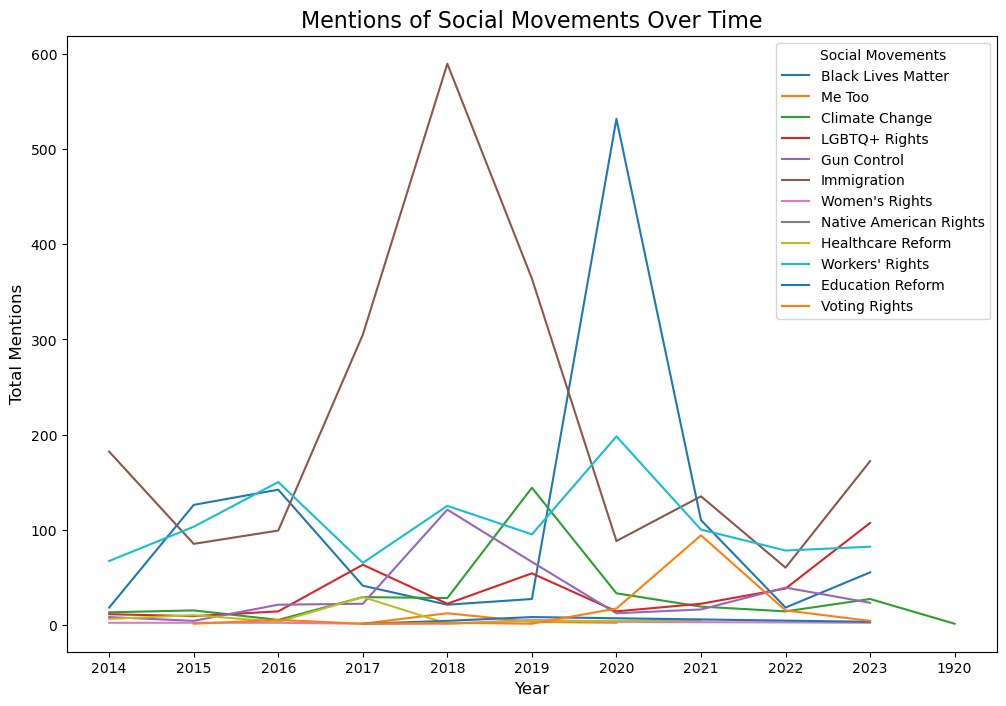

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

for movement, data in movement_data.items():
    sns.lineplot(data=data, x='Year', y='TotalMentions', label=movement)

plt.title('Mentions of Social Movements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Mentions', fontsize=12)
plt.legend(title="Social Movements")
plt.show()


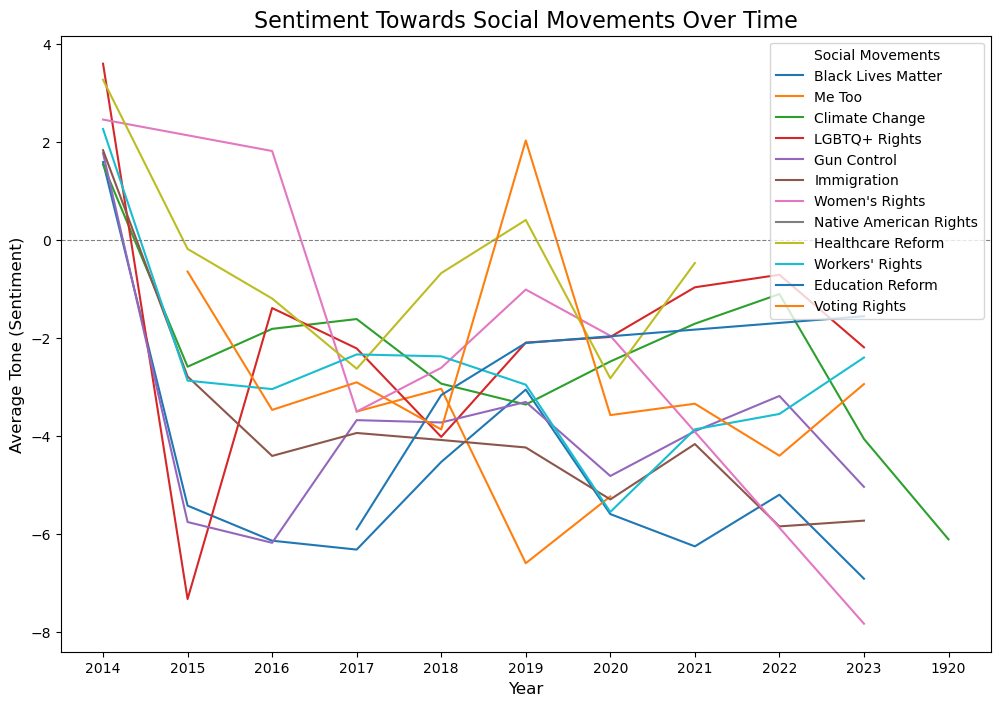

In [17]:
plt.figure(figsize=(12, 8))

for movement, data in movement_data.items():
    sns.lineplot(data=data, x='Year', y='AvgTone', label=movement)

plt.title('Sentiment Towards Social Movements Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Tone (Sentiment)', fontsize=12)
plt.legend(title="Social Movements")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.show()
